# Annual Averaged Hazard Score - Metrics

In this exercise we perform the calculation of the basic metrics of AAHS in the Natanebi river basin. 

We first load useful libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import xarray as xr
import rasterio
from wrf import (getvar, interplevel, to_np, latlon_coords, CoordPair, xy_to_ll, ll_to_xy)
from scipy.interpolate import griddata
import geopandas as gp
from netCDF4 import Dataset,num2date,date2num
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Then, we load the wind NetCDF file provided with flood depth at a national level. 

In [2]:
d10_file = './DATA/natanebi_AAHS_wind.nc'
dsw        = xr.open_dataset(d10_file)

d20_file = './DATA/natanebi_AAHS_hail.nc'
dsh        = xr.open_dataset(d20_file)

d30_file = './DATA/natanebi_AAHS_flood.nc'
dsf        = xr.open_dataset(d30_file)

d40_file = './DATA/natanebi_AAHS_drought.nc'
dsd        = xr.open_dataset(d40_file)

hail = dsh.Max_Diam
wind = dsw.Max_Vel
flood = dsf.myvar
drought = dsd.Band1

We crop the wind, hail and drought datasets into the flood boundaries

In [9]:
min_lat=np.min(flood.lat.data)-0.5
max_lat=np.max(flood.lat.data)+0.5
min_lon=np.min(flood.lon.data)-0.5
max_lon=np.max(flood.lon.data)+0.5

cropw = wind.where((wind.XLAT > min_lat) & (wind.XLAT < max_lat) & (wind.XLONG > min_lon) & (wind.XLONG < max_lon),drop=True)
croph = hail.where((hail.XLAT > min_lat) & (hail.XLAT < max_lat) & (hail.XLONG > min_lon) & (hail.XLONG < max_lon),drop=True)
cropd = drought.where((drought.lat > min_lat) & (drought.lat < max_lat) & (drought.lon > min_lon) & (drought.lon < max_lon),drop=True)

With a smaller size, it is now easy to regrid wind, hail and drought into the flood grid

In [10]:
lats=cropw.XLAT
lons=cropw.XLONG

latd=cropd.lat
lond=cropd.lon

DYi = np.linspace(np.min(latd),np.max(latd),len(latd))
DXi = np.linspace(np.min(lond),np.max(lond),len(lond))
DX, DY = np.meshgrid(DXi,DYi)

Yi = np.linspace(np.min(flood.lat.data),np.max(flood.lat.data),len(flood))
Xi = np.linspace(np.min(flood.lon.data),np.max(flood.lon.data),len(flood[0]))
X, Y = np.meshgrid(Xi,Yi)

nvalsw = griddata((lons.data.ravel(),
                                    lats.data.ravel()),
                                    cropw.data.ravel(),
                                    (X,Y),
                                    method='linear')

nvalsh = griddata((lons.data.ravel(),
                                    lats.data.ravel()),
                                    croph.data.ravel(),
                                    (X,Y),
                                    method='linear')

nvalsd = griddata((DX.ravel(),
                                    DY.ravel()),
                                    cropd.data.ravel(),
                                    (X,Y),
                                    method='linear')

We calculate the sum of all AAHS scores

In [11]:
thesum = [sum(x) for x in zip(nvalsw, nvalsh, nvalsd, flood.data)]    

We calculate the dominand of all AAHS scores

In [12]:
nvalsw = np.array(nvalsw)
nvalsh = np.array(nvalsh)
nvalsd = np.array(nvalsd)
floody = np.array(flood.data)

nvalsw = np.nan_to_num(nvalsw)
nvalsh = np.nan_to_num(nvalsh)
nvalsh = np.nan_to_num(nvalsh)

themax = np.maximum.reduce([nvalsw,nvalsh,nvalsd,floody])
# themax = np.vstack([cropw,croph,floody]).max(axis=0)


diff1 = [[ele2 - ele1 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(themax,nvalsh)]
diff2 = [[ele2 - ele1 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(themax,nvalsw)]
diff4 = [[ele2 - ele1 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(themax,nvalsd)]
diff3 = [[ele2 - ele1 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(themax, floody)]

diff1 = np.array(diff1)
diff2 = np.array(diff2)
diff3 = np.array(diff3)
diff4 = np.array(diff4)

diff1[diff1==0]=1
diff2[diff2==0]=1
diff3[diff3==0]=1
diff4[diff4==0]=1

diff1[diff1<0]=np.nan
diff2[diff2<0]=np.nan
diff3[diff3<0]=np.nan
diff4[diff4<0]=np.nan

maskedh = nvalsh * diff1
maskedw = nvalsw * diff2
maskedd = nvalsd * diff4
maskedf = floody * diff3

And we estimate the percentage of the contribution of each hazard separately

In [13]:
per_w = [[(ele2 / ele1)*100 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(thesum, nvalsw)]

per_h = [[(ele2 / ele1)*100 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(thesum, nvalsh)]

per_d = [[(ele2 / ele1)*100 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(thesum, nvalsd)]

per_f = [[(ele2 / ele1)*100 for ele1, ele2 in zip(sub1, sub2)]
        for sub1, sub2 in zip(thesum, flood.data)]

We define the boundaries of the Natanebi river basin

In [14]:
df = gp.read_file('./DATA/NataEPSG.shp')
#df = df.to_crs(epsg=4326)
x_min, y_min, x_max, y_max = df.total_bounds

We now plot the sum

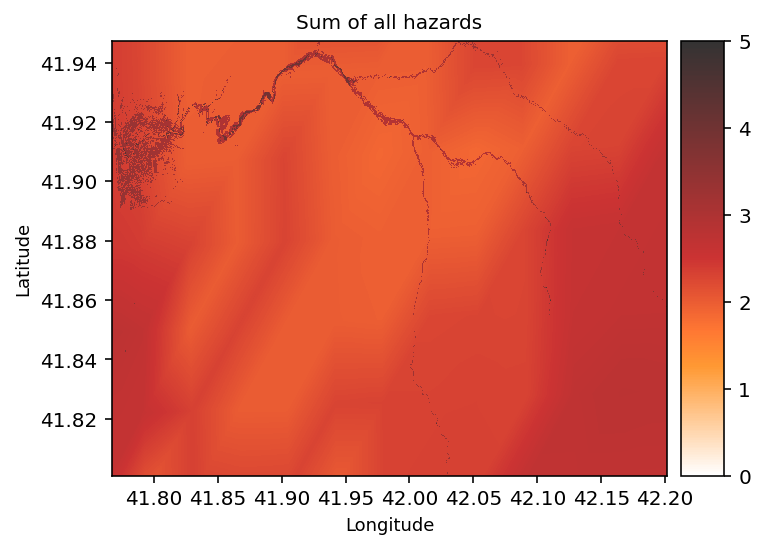

In [15]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Sum of all hazards', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('gist_heat_r')
mesh = ax.pcolormesh(X,Y,thesum,vmin=0, vmax=5,alpha=0.8, cmap=cmap);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()

We plot the dominant

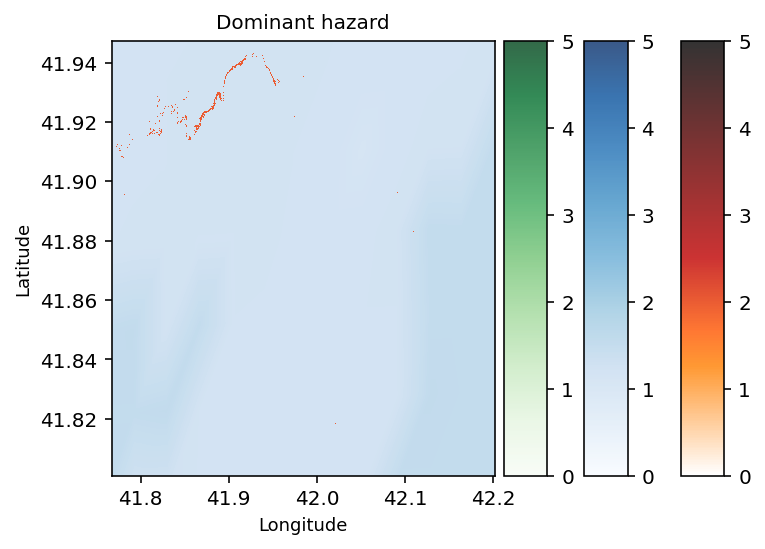

In [16]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Dominant hazard', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('gist_heat_r')
cmap2 = plt.get_cmap('Blues')
cmap3 = plt.get_cmap('Greens')
mesh = ax.pcolormesh(X,Y,maskedf,vmin=0, vmax=5,alpha=0.8, cmap=cmap);
mesh2 = ax.pcolormesh(X,Y,maskedh,vmin=0, vmax=5,alpha=0.8, cmap=cmap2);
mesh3 = ax.pcolormesh(X,Y,maskedw,vmin=0, vmax=5,alpha=0.8, cmap=cmap3);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.colorbar(mesh2, ax=ax, shrink=1, pad=.02, aspect=10)
plt.colorbar(mesh3, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()

We plot the wind percentage

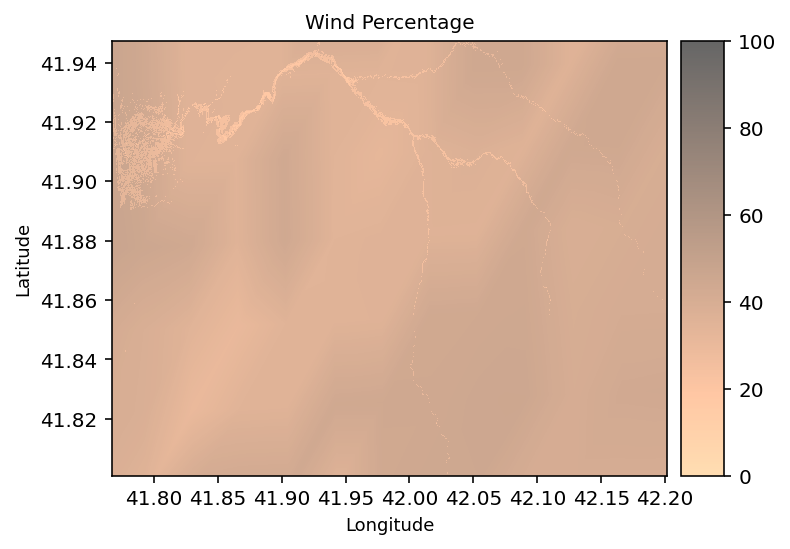

In [19]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Wind Percentage', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('copper_r')
mesh = ax.pcolormesh(X,Y,per_w,vmin=0, vmax=100,alpha=0.6, cmap=cmap);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()

We plot the hail percentage

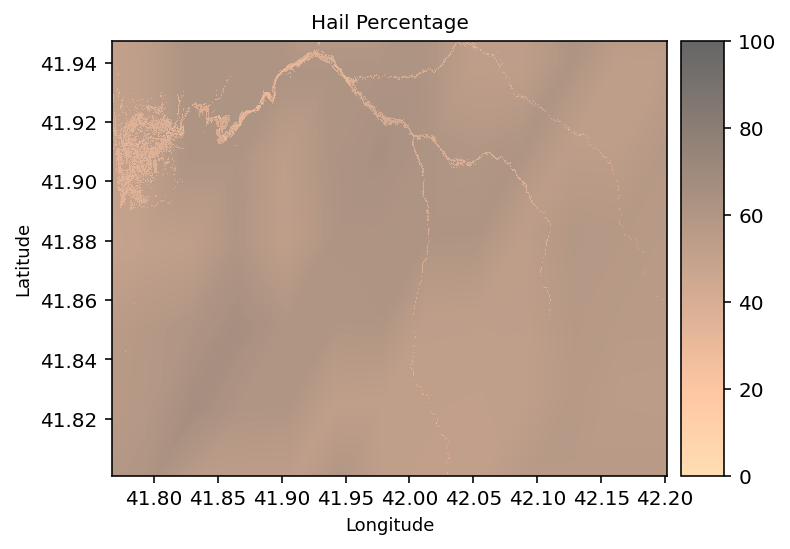

In [21]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Hail Percentage', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('copper_r')
mesh = ax.pcolormesh(X,Y,per_h,vmin=0, vmax=100,alpha=0.6, cmap=cmap);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()

We plot the flood percentage

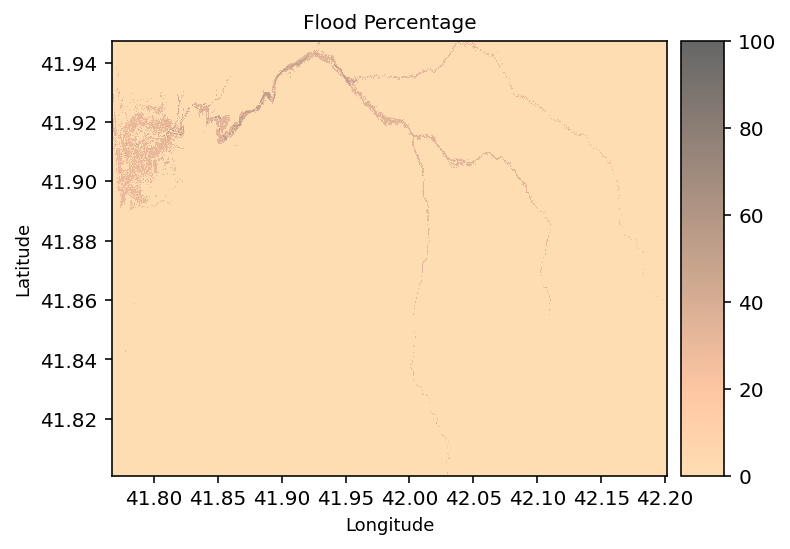

In [22]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Flood Percentage', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('copper_r')
mesh = ax.pcolormesh(X,Y,per_f,vmin=0, vmax=100,alpha=0.6, cmap=cmap);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()

We plot the drought percentage

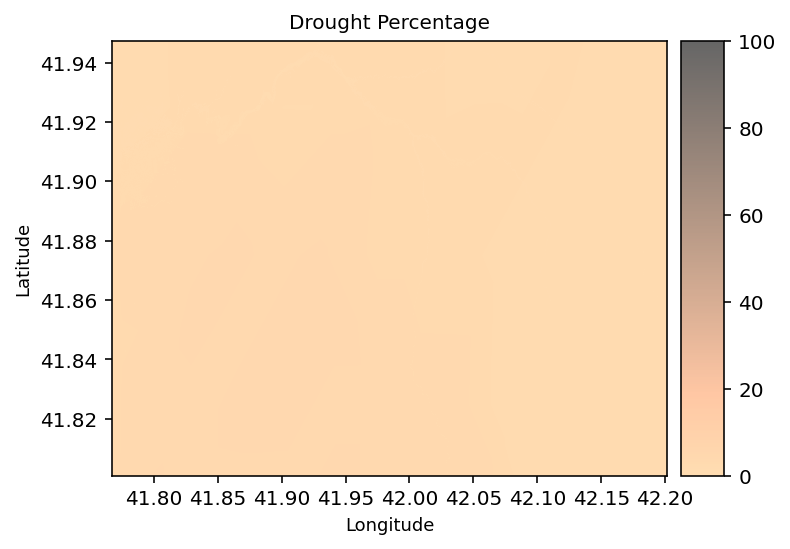

In [23]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_title('Drought Percentage', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('copper_r')
mesh = ax.pcolormesh(X,Y,per_d,vmin=0, vmax=100,alpha=0.6, cmap=cmap);
plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()